# DeepFourier
a project by Lorenzo, Sébastien, Péter and Benjamin

NB: please Use this [download link](https://mega.nz/#F!4apUwKwZ!OsLSY_w7OD85mZRPcdAmMQ) for the very big files.


Welcome to this short demonstration for the **DeepFourier** project. This demo contains spoilers for the report. So if you haven't already, please read the report before starting this jupyter notebook.

In this demo we will walk you through the important aspects of the code that we wrote for our project.

We will :
* build the network layers (i.e. the TensorFlow graph) for our different architectures
* load pre-trained weigths from different IceBreaker phases / PiczakNet standalone training / MSTNet Spectrogram Forcing
* calculate test accuracies for all of them
* plot some learned kernels from the first DeepFourier layer
* plot test accuracies
* plot some activations (the outputs of the activation functions right before the PiczakNet part of the respective network (i.e. where the Mel-spectrograms used to be) )

As mentioned in the report, we have these 3 classes in our dataset: air conditioner (AI), car horn (CA),
children playing (CH), dog bark (DO), drilling (DR), engine idling (EN), gun shot (GU), jackhammer (JA), siren (SI), street music (ST).

As a reminder, we used these two networks, HeuriNet and MSTNet, for end-to-end sound classification:
    
![](arch.png)

Before the demo even starts, we have run this procedure, a.k.a. the IceBreaker, beforehand:

![](ib.png)

(hint1: "frozen" in the picture is identical to ``` Trainable = False ``` in TensorFlow.)<br/>
(hint2: "DeepFourier" is a sub-network and is ``` Trainable``` in Phases 1, 2 and 3.)

Apart from the IceBreaker, we did a "control group", where the entire network (DeepFourier part and PiczakNet part) is randomly initialized with Xavier and then trained (with the entire network ``` Trainable```).

From all these trainings, we stored the learned weights, to save you some computation time.

Now please start the demo by importing the needed libraries and the learned weights:

In [1]:
from __future__ import absolute_import, division, print_function 
import numpy as np
import os
import sys
sys.path.append(os.path.join('.', '..')) 
import utils 
import scipy.io
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected, convolution2d, flatten, max_pool2d
from tensorflow.python.ops.nn import relu, sigmoid, tanh, softmax
from tensorflow.python.layers.pooling import MaxPooling1D
from sklearn.metrics import confusion_matrix
data_folder = "./data/"
learned_weights_all_files=["Heuri_P1","Heuri_P2","Heuri_P3","Heuri_all","MST_sf","MST_P1","MST_P2","MST_P3","MST_all","Piczak"]

In the last line, we introduced a lot of filenames. They represent the pre-trained weights that we will load to our network in the form of .mat files.
We have:
* ``` "Piczak" ```: the weights from the stand-alone PiczakNet back from the days where we trained it with Mel-spectrograms as input.
* ``` "Heuri_P1" ```: the trained weights from Phase 1 of the IceBreaker, for the HeuriNet architecture. If you open Heuri_P1.mat in Matlab, you will find that the DeepFourier part (```DF_conv1d_...```) consists of 4 tensors (kernels and biases), corresponding to 2 layers (not surprisingly). Keep in mind that the weights of the PiczakNet layers (everything without ```DF``` in the name) are still the same as before the IceBreaker (i.e. still the same as in ``` "Piczak" ```), because they were frozen in Phase 1. 
* ``` "Heuri_P2" ```: Phase 2. The weights of the first layer of PiczakNet (```conv2d_1_kernel``` and ```conv2d_1_bias```) should have changed since ``` "Heuri_P1" ```, because in Phase 2 they have been ```Trainable``` for the first time. The weights of the DeepFourier also changed.
* ```"Heuri_all"```:  These are the weights from the "control group" (for the HeuriNet architecture).
* ``` "MST_..." ```: The same stuff as before, but from the MSTNet. 
* ``` "MST_sf" ```: "sf" for "Spectrogram Forcing". This exists only for MSTNet. These are the weights from when we trained the DeepFourier part of the network (i.e. the first 3 conv-1D layers) alone, with the Mel-spectrogram as a target (the only regression problem of the project).

Keep in mind that we will use only a subset of the whole data set (from now on called the "example data").

So let's import some weights and calculate some stuff:

In [2]:
#Initialization of final lists we'll use
HeurNet_test=[None]*4
HeurNet_act=[None]*4
MST_test=[None]*5
MST_act=[None]*5
#Increment for filling up the lists of test errors at the end; each increment relates to one training 
#(i.e. different networks / different IceBreaker phases)
step_h=0
step_m=0

print('---------------------STARTING FORWARD PASSES OF DIFFERENT MODELS AT DIFFERENT TRAINING PHASES--------------')    
for learned_weights_file in learned_weights_all_files:
    tf.reset_default_graph()
    # "ptw" for "pre-trained weights"
    ptw = scipy.io.loadmat("./weights/" + learned_weights_file + ".mat")
    if "Heuri" in learned_weights_file:
        include_DF_HeurNet = True
        include_DF_MST = False
    elif "MST" in learned_weights_file:
        include_DF_HeurNet = False
        include_DF_MST = True
    else:
        include_DF_HeurNet = False
        include_DF_MST = False
    ################################
    ###   GET  TRAINED WEIGHTS   ###
    ################################
    if include_DF_HeurNet or include_DF_MST: #the first 2 DeepFourier layers
        pretrained_conv1d_1_kernel_DF = ptw['DF_conv1d_1_kernel']#the entries in the .mat file
        pretrained_conv1d_1_bias_DF    =ptw['DF_conv1d_1_bias']
        pretrained_conv1d_2_kernel_DF  =ptw['DF_conv1d_2_kernel']
        pretrained_conv1d_2_bias_DF    =ptw['DF_conv1d_2_bias']
    if include_DF_MST: #the 3rd DeepFourier layer (exists only in MST)
        pretrained_conv1d_3_kernel_DF  =ptw['DF_conv1d_3_kernel']
        pretrained_conv1d_3_bias_DF    =ptw['DF_conv1d_3_bias']
    pretrained_conv2d_1_kernel_PZ = ptw['conv2d_1_kernel']
    pretrained_conv2d_1_bias_PZ   = ptw['conv2d_1_bias']
    pretrained_conv2d_2_kernel_PZ = ptw['conv2d_2_kernel']
    pretrained_conv2d_2_bias_PZ =   ptw['conv2d_2_bias']
    pretrained_dense_1_kernel_PZ =  ptw['dense_1_kernel']
    pretrained_dense_1_bias_PZ =    ptw['dense_1_bias']
    pretrained_dense_2_kernel_PZ =  ptw['dense_2_kernel']
    pretrained_dense_2_bias_PZ =    ptw['dense_2_bias']
    pretrained_output_kernel_PZ =   ptw['output_kernel']
    pretrained_output_bias_PZ =     ptw['output_bias']

    nchannels = 1
    segment_length = 20992

    ###################################
    ###   NETWORK HYPERPARAMETERS   ###
    ###################################


    ###DEEP_FOURIER LAYERS HYPERPARAMETERS
    if include_DF_HeurNet:
        # Conv1, MaxPool1 parameters
        DF_padding_conv1 = "valid"
        DF_filters_1 = 80 
        DF_kernel_size_1 = 155
        DF_strides_conv1 = 10
        DF_padding_pool1 = "valid"
        DF_pool_size_1 = 9
        DF_strides_pool1 = 3
        # Conv2, MaxPool2 parameters
        DF_padding_conv2 = 'valid'
        DF_filters_2 = 60 
        DF_kernel_size_2 = 15
        DF_strides_conv2 = 4
        DF_padding_pool2 = 'valid'
        DF_pool_size_2 = 9
        DF_strides_pool2 = 4

    if include_DF_MST:
        # Conv1
        DF_padding_conv1 = "same"
        DF_filters_1 = 512  
        DF_kernel_size_1 = 1024
        DF_strides_conv1 = 512
        # Conv2
        DF_padding_conv2 = 'same'
        DF_filters_2 = 256  
        DF_kernel_size_2 = 3
        DF_strides_conv2 = 1
        # Conv3
        DF_padding_conv3 = 'same'
        DF_filters_3 = 60  
        DF_kernel_size_3 = 3
        DF_strides_conv3 = 1

    frequency_bins, time_bins, n_channels = 60, 41, 1
    image_shape = [frequency_bins,time_bins,n_channels]

    #INPUT PLACEHOLDER
    if include_DF_HeurNet or include_DF_MST: #raw waveform as input
        x_pl_1 = tf.placeholder(tf.float32, [None, segment_length, nchannels], name='waveformSegment')
    else: #spectrogram as input
        x_pl_1 = tf.placeholder(tf.float32, [None, frequency_bins, time_bins, nchannels], name='spectrogram')

    
    ###PICZAKNET HYPERPARAMETERS
    # First convolutional layer
    n_filter_1 = 80
    kernel_size_1 = [57,6]
    kernel_strides_1=(1,1)
    l2_1=0.001

    # First MaxPool layer
    pool_size_1 = (4,3)
    pool_strides_1=(1,3)
    padding_1="valid"

    ### Second convolutional layer
    n_filter_2 = 80
    kernel_size_2=[1,3]
    kernel_strides_2=(1,1)
    l2_2=0.001

    # Scond MaxPool layer
    pool_size_2=(1,3)
    pool_strides_2=(1,3)
    padding_2="valid"

    #Third (dense) layer
    num_units_3 = 5000
    l2_3=0.001

    #Fourth (dense) layer
    num_units_4 = 5000
    l2_4=0.001

    #Output softmax layer (10 classes in UrbanSound8K)
    num_classes=10
    l2_output=0.001

    ###OUTPUT PLACEHOLDER VARIABLES
    y_pl = tf.placeholder(tf.float64, [None, num_classes], name='yPlaceholder')
    y_pl = tf.cast(y_pl, tf.float32)

    ##############################
    ###   NETWORK DEFINITION   ###
    ##############################

    print('----------------------------------------------')
    print("building network and loading weights for: " + learned_weights_file)
    if include_DF_HeurNet:
        ### DEEP FOURIER NETWORK
        with tf.variable_scope('DF_convLayer1'):
            ### CONV1 LAYER
            # Layer build
            z1 = tf.layers.conv1d(   inputs=x_pl_1,
                                     filters=DF_filters_1,
                                     kernel_size=DF_kernel_size_1,
                                     strides=DF_strides_conv1,
                                     padding=DF_padding_conv1,
                                     activation=tf.nn.relu,
                                     use_bias=True,
                                     kernel_initializer=tf.constant_initializer(pretrained_conv1d_1_kernel_DF),
                                     bias_initializer=tf.constant_initializer(pretrained_conv1d_1_bias_DF),
                                     name="DF_conv_1",
                                    )
            ### MAX_POOL1
            pool1 = MaxPooling1D(    pool_size=DF_pool_size_1,
                                            strides=DF_strides_pool1,
                                            padding=DF_padding_pool1,
                                            name='DF_pool_1'
                                        )

            # Activation pass, pooling
            zhat1 = (pool1(z1))

        with tf.variable_scope('DF_convLayer2'):
            ### CONV2 LAYER
            # Layer build
            z2 = tf.layers.conv1d(   inputs=zhat1,
                                     filters=DF_filters_2,
                                     kernel_size=DF_kernel_size_2,
                                     strides=DF_strides_conv2,
                                     padding=DF_padding_conv2,
                                     activation=tf.nn.relu,
                                     use_bias=True,
                                     kernel_initializer=tf.constant_initializer(pretrained_conv1d_2_kernel_DF),
                                     bias_initializer=tf.constant_initializer(pretrained_conv1d_2_bias_DF),
                                     name="DF_conv_2",
                                    )
            ### MAX_POOL2
            pool2 = MaxPooling1D(    pool_size=DF_pool_size_2,
                                            strides=DF_strides_pool2,
                                            padding=DF_padding_pool2,
                                            name='DF_pool_2'
                                        )

            # Activation pass, pooling
            zhat2 = (pool2(z2))
            # Reshape to match the spectrogram format (from 41x60 to 60x41x1)
            zhat2 = tf.transpose(zhat2, perm=[0,2,1])
            activationBeforePZ = tf.expand_dims(zhat2, axis=3)
    elif include_DF_MST:
        with tf.variable_scope('DF_convLayer1'):
            ### CONV1 LAYER
            z1 = tf.layers.conv1d(inputs=x_pl_1,
                                  filters=DF_filters_1,
                                  kernel_size=DF_kernel_size_1,
                                  strides=DF_strides_conv1,
                                  padding=DF_padding_conv1,
                                  activation=tf.nn.relu,
                                  use_bias=True,
                                  kernel_initializer=tf.constant_initializer(pretrained_conv1d_1_kernel_DF),
                                  bias_initializer=tf.constant_initializer(pretrained_conv1d_1_bias_DF),
                                  name="DF_conv_1",
                                  )
        with tf.variable_scope('DF_convLayer2'):
            ### CONV2 LAYER
            z2 = tf.layers.conv1d(inputs=z1,
                                  filters=DF_filters_2,
                                  kernel_size=DF_kernel_size_2,
                                  strides=DF_strides_conv2,
                                  padding=DF_padding_conv2,
                                  activation=tf.nn.relu,
                                  use_bias=True,
                                  kernel_initializer=tf.constant_initializer(pretrained_conv1d_2_kernel_DF),
                                  bias_initializer=tf.constant_initializer(pretrained_conv1d_2_bias_DF),
                                  trainable=True,
                                  name="DF_conv_2",
                                  )

        with tf.variable_scope('DF_convLayer3'):
            ### CONV3 LAYER
            z3 = tf.layers.conv1d(inputs=z2,
                                  filters=DF_filters_3,
                                  kernel_size=DF_kernel_size_3,
                                  strides=DF_strides_conv3,
                                  padding=DF_padding_conv3,
                                  activation=tf.nn.tanh,
                                  use_bias=True,
                                  kernel_initializer=tf.constant_initializer(pretrained_conv1d_3_kernel_DF),
                                  bias_initializer=tf.constant_initializer(pretrained_conv1d_3_bias_DF),
                                  trainable=True,
                                  name="DF_conv_3",
                                  )
            # Reshape to match the spectrogram format (from 41x60 to 60x41x1)
            z3 = tf.transpose(z3, perm=[0, 2, 1])
            activationBeforePZ = tf.expand_dims(z3, axis=3)
    else: #test error of standalone PiczakNet
        activationBeforePZ=x_pl_1

    ### PICZAK NETWORK
    # Convolutional layers
    with tf.variable_scope('PZ_convLayer1'):
        if not include_DF_HeurNet and not include_DF_MST:
            print("----------Piczak building (1 out of 1)--------")
        conv1 = tf.layers.conv2d(
            kernel_initializer=tf.constant_initializer(pretrained_conv2d_1_kernel_PZ),
            bias_initializer=tf.constant_initializer(pretrained_conv2d_1_bias_PZ),
            inputs=activationBeforePZ,
            filters=n_filter_1,
            kernel_size=kernel_size_1,
            strides=kernel_strides_1,
            padding=padding_1,
            activation=tf.nn.relu,
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=l2_1))
        x=conv1
        pool1 = max_pool2d(x, kernel_size=pool_size_1,stride=pool_strides_1, padding=padding_1)
        x = pool1

    with tf.variable_scope('PZ_convLayer2'):
        conv2 = tf.layers.conv2d(
            kernel_initializer=tf.constant_initializer(pretrained_conv2d_2_kernel_PZ),
            bias_initializer=tf.constant_initializer(pretrained_conv2d_2_bias_PZ),
            inputs=x,
            filters=n_filter_2,
            kernel_size=kernel_size_2,
            strides=kernel_strides_2,
            padding=padding_2,
            activation=tf.nn.relu,
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=l2_2))
        x = conv2
        pool2 = max_pool2d(x,kernel_size=pool_size_2, stride=pool_strides_2, padding=padding_2)
        x = pool2
        # We flatten x for the dense layers that come after
        x = flatten(x)

    # Dense layers
    with tf.variable_scope('PZ_denseLayer3'):
        dense3 = tf.layers.dense(
            kernel_initializer=tf.constant_initializer(pretrained_dense_1_kernel_PZ),
            bias_initializer=tf.constant_initializer(pretrained_dense_1_bias_PZ),
            inputs=x,
            units=num_units_3,
            activation=tf.nn.relu,
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=l2_3),
        )
        x = dense3

    with tf.variable_scope('PZ_denseLayer4'):
        dense4 = tf.layers.dense(
            kernel_initializer=tf.constant_initializer(pretrained_dense_2_kernel_PZ),
            bias_initializer=tf.constant_initializer(pretrained_dense_2_bias_PZ),
            inputs=x,
            units=num_units_4,
            activation=tf.nn.relu,
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=l2_4),
        )
        x = dense4

    with tf.variable_scope('PZ_output_layer'):
        dense_out = tf.layers.dense(
            kernel_initializer=tf.constant_initializer(pretrained_output_kernel_PZ),
            bias_initializer=tf.constant_initializer(pretrained_output_bias_PZ),
            inputs=x,
            units=num_classes,
            activation=None,
            kernel_regularizer=tf.contrib.layers.l2_regularizer(scale=l2_output),
        )
        y = tf.nn.softmax(dense_out)

    ####################################################
    ###   LOSS, TRAINING AND PERFORMANCE DEFINITION  ###
    ####################################################

    with tf.variable_scope('loss'):
        # computing cross entropy per sample
        cross_entropy = -tf.reduce_sum(y_pl * tf.log(y+1e-8), reduction_indices=[1])
        # averaging over samples
        cross_entropy = tf.reduce_mean(cross_entropy)

    with tf.variable_scope('performance'):
        # making a one-hot encoded vector of correct (1) and incorrect (0) predictions
        correct_prediction = tf.equal(tf.argmax(y, axis=1), tf.argmax(y_pl, axis=1))
        # averaging the one-hot encoded vector
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    ##############################
    ###    TESTING on fold 10  ###
    ##############################

    data = scipy.io.loadmat(data_folder + 'data.mat')

    if include_DF_HeurNet or include_DF_MST:
        test_data=np.expand_dims(data['ob_wav'],axis=-1)
    else:
        test_data=np.expand_dims(data['ob_spcgm'],axis=-1)
    y_test_true=utils.onehot(np.transpose(data['lb']), num_classes) #One-hot encoding labels

    eat_this = {x_pl_1: test_data, y_pl: y_test_true}
    fetches_test = [y, cross_entropy, accuracy]

    random_obs_wav = scipy.io.loadmat("data/RANDOM_OBS")['picked_obs']
    print('---------------FORWARD PASS-------------------')

    gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
    sess=tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts))
    sess.run(tf.global_variables_initializer())
    res = sess.run(fetches=fetches_test, feed_dict=eat_this)

    if include_DF_HeurNet or include_DF_MST:
        random_obs_wav = np.expand_dims(random_obs_wav, -1)
        eat_the_random_obs = {x_pl_1: random_obs_wav}
        activations_of_wav_signals = sess.run(activationBeforePZ, eat_the_random_obs)
    sess.close()

    y_test_pred = res[0]
    test_loss = res[1]
    test_accuracy = res[2]
    #from softmax to class
    y_test_pred = np.argmax(y_test_pred, axis=1)
    y_test_true = utils.onehot_inverse(y_test_true)
    conf_mat = confusion_matrix(y_test_true, y_test_pred, labels=range(10))
    #to deal with the class imbalance: 
    cba = utils.classbal_acc(conf_mat) #Take the Class Balanced Accuracy (CBA, i.e. the recall averaged over all classes)

    ### for the test error plots ###
    
    #HeuriNet
    if include_DF_HeurNet:
        #List of HeuriNet CBAs across the IceBreaker + Heuri_all (4 values)
        HeurNet_test[step_h]=cba
        #List of HeuriNet activations (after the DF layers), across the IceBreaker + Heuri_all (4 values)
        HeurNet_act[step_h]=activations_of_wav_signals
        step_h+=1

    #MST
    elif include_DF_MST:
        #List of MSTNet CBAs after spectrogram fitting + across the IceBreaker + MST_all (5 values)
        MST_test[step_m]=cba
        #List of MSTNet activations (after the DF layers), after spectrogram fitting + across the IceBreaker + MST_all (5 values)
        MST_act[step_m]=activations_of_wav_signals
        step_m+=1

    #PiczakNet
    else:
        #Test error for stand-alone PiczakNet with Mel-spectrogram as input
        Piczak_test=cba
        
print("........DONE!")

---------------------STARTING FORWARD PASSES OF DIFFERENT MODELS AT DIFFERENT TRAINING PHASES--------------
----------------------------------------------
building network and loading weights for: Heuri_P1
---------------FORWARD PASS-------------------
----------------------------------------------
building network and loading weights for: Heuri_P2
---------------FORWARD PASS-------------------
----------------------------------------------
building network and loading weights for: Heuri_P3
---------------FORWARD PASS-------------------
----------------------------------------------
building network and loading weights for: Heuri_all
---------------FORWARD PASS-------------------
----------------------------------------------
building network and loading weights for: MST_sf
---------------FORWARD PASS-------------------
----------------------------------------------
building network and loading weights for: MST_P1
---------------FORWARD PASS-------------------
-------------------------

In this big loop above, we did, in a nutshell, the following:
* Built our different architectures
* Loaded pre-trained weigths from different IceBreaker phases / PiczakNet standalone training / Spectrogram Forcing
* Calculated test accuracies for all of them
* Calculated the activations for all these networks for 10 randomly picked observations.

Now we show the weights of some learned kernels:

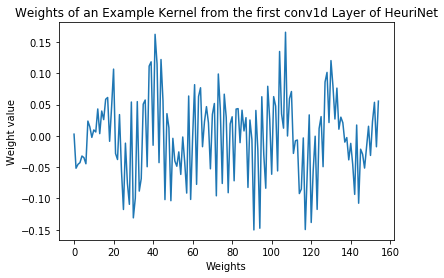

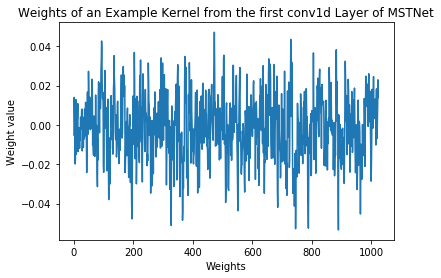

In [3]:
import matplotlib.pyplot as plt
### Plotting examples of kernel weights for HeuriNet and MSTNet ###
# HeuriNet
out = scipy.io.loadmat('weights/Heuri_P3.mat')
# Data for plotting
conv1d_weights = out['DF_conv1d_1_kernel']
x = np.arange(0,155)

fig, ax = plt.subplots()

kernel_to_plot = 10 #Select any kernel from 1-80

ax.plot(x, conv1d_weights[:,:,kernel_to_plot]) 

ax.set(xlabel='Weights', ylabel='Weight value',
       title='Weights of an Example Kernel from the first conv1d Layer of HeuriNet')

plt.show()

# MSTNet (NOTE: The kernel width here is 1024, so it's harder to see details clearly on the plot compared to HeuriNet)
out = scipy.io.loadmat('weights/MST_P3.mat')
# Data for plotting
conv1d_weights = out['DF_conv1d_1_kernel']
x = np.arange(0,1024)

fig, ax = plt.subplots()

kernel_to_plot = 14 #Select any kernel from 1-80

ax.plot(x, conv1d_weights[0:1024,:,kernel_to_plot])

ax.set(xlabel='Weights', ylabel='Weight value',
       title='Weights of an Example Kernel from the first conv1d Layer of MSTNet')

plt.show()

And these are the test accuracies (computed on the 10th fold):

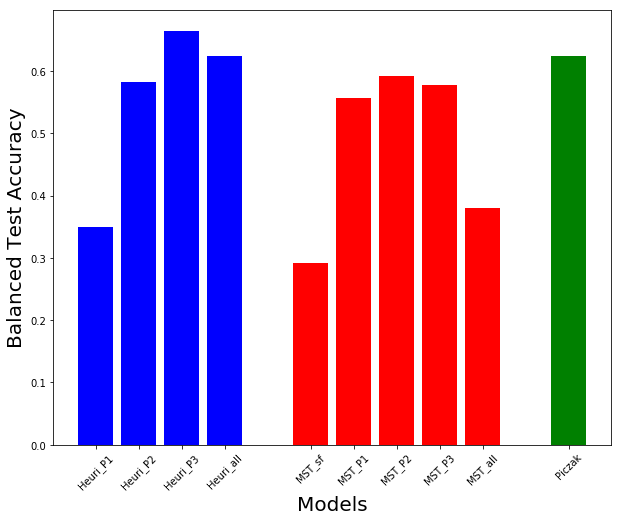

In [4]:

import matplotlib as mpl

#Create data axis and bars axis
y = HeurNet_test+MST_test+[Piczak_test]
x = [0, 1, 2, 3, 5, 6, 7, 8, 9, 11]

# Plot bars
mpl.rcParams['figure.figsize'] = (10,8)
barplot = plt.bar(x, y, color=['blue', 'blue', 'blue', 'blue', 'red', 'red', 'red', 'red', 'red', 'green'])

# Create names on the x-axis
bars = ('Heuri_P1', 'Heuri_P2', 'Heuri_P3','Heuri_all','MST_sf', 'MST_P1', 'MST_P2','MST_P3','MST_all','Piczak')
plt.xticks(x, bars, rotation=45)

# Create axis labels
plt.xlabel('Models', fontsize=20)
plt.ylabel('Balanced Test Accuracy', fontsize=20)

# Show graphic
plt.show()

Please refer to the report for interpretation of these values. Now we will compute the Mel-spectrograms of the example data, the same way that Piczak would have computed them: 

In [5]:
import librosa #please install this package
all_spcgm = np.zeros((0, 60, 41), np.float64)
for j in range(random_obs_wav.shape[0]):
    spcgm = librosa.feature.melspectrogram(random_obs_wav[j], hop_length=512, n_fft=1024, sr=22050, n_mels=60) #how Piczak does it
    spcgm = spcgm[:, :41] #for some reason the spcgm returned by spcgm has a width of 42 so we have to trim it to 41
    spcgm = librosa.logamplitude(spcgm) #how Piczak does it
    all_spcgm = np.vstack((all_spcgm, [spcgm]))
#the spectrograms of the example data are now stored in all_spcgm

...the Mel-spectrograms and the activations (right before PiczakNet) of the example data, for HeuriNet:

horizontal direction: time, vertical direction: frequency


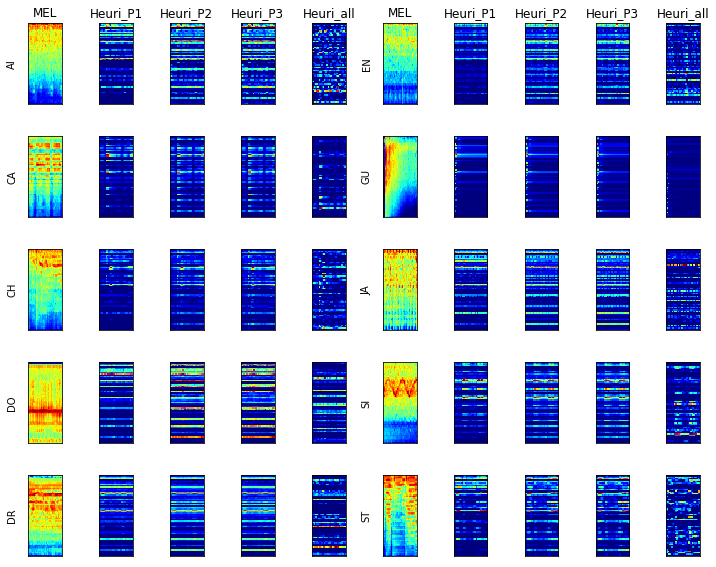

horizontal direction: time, vertical direction: frequency


In [6]:
def axes_work(axo):
    axo.xaxis.set_ticks_position('none') 
    axo.yaxis.set_ticks_position('none') 
    axo.set_yticklabels([])
    axo.set_xticklabels([])

fig, axes = plt.subplots(5,10) 
mpl.rcParams['figure.figsize'] = [15,12]
fig.tight_layout()   
audioclass = ['AI', 'CA', 'CH', 'DO', 'DR', 'EN', 'GU', 'JA', 'SI', 'ST']
print("horizontal direction: time, vertical direction: frequency")
for i in range(2):
    for j in range(5):
        ax_idx = i*5 + j*10
        class_idx = i*5 + j
  
        # Plot MEL-spectrogram
        ax = axes.flatten()[ax_idx]
        axes_work(ax)
        ax.set_ylabel(audioclass[class_idx])
        if((class_idx == 0) | (class_idx == 5)):
            ax.set_title('MEL');
        to_plot = all_spcgm[class_idx,:,:]
        img = ax.imshow(to_plot, interpolation='nearest', cmap='jet', extent = [0, 1, 0, 1])
        ax.set_aspect('auto')
        
        # Plot Heuri_P1
        ax = axes.flatten()[ax_idx +1]
        axes_work(ax)
        if((class_idx == 0) | (class_idx == 5)):
            ax.set_title('Heuri_P1');
        to_plot = np.reshape(HeurNet_act[0][class_idx,:,:],[60,41])
        img = ax.imshow(to_plot, interpolation='nearest', cmap='jet', extent = [0, 1, 0, 1])
        ax.set_aspect('auto')
        
        # Plot Heuri_P2
        ax = axes.flatten()[ax_idx +2]
        axes_work(ax)
        if((class_idx == 0) | (class_idx == 5)):
            ax.set_title('Heuri_P2');
        to_plot = np.reshape(HeurNet_act[1][class_idx,:,:],[60,41])
        img = ax.imshow(to_plot, interpolation='nearest', cmap='jet', extent = [0, 1, 0, 1])
        ax.set_aspect('auto')
        
        # Plot Heuri_P3
        ax = axes.flatten()[ax_idx +3]
        axes_work(ax)
        if((class_idx == 0) | (class_idx == 5)):
            ax.set_title('Heuri_P3');
        to_plot = np.reshape(HeurNet_act[2][class_idx,:,:],[60,41])
        img = ax.imshow(to_plot, interpolation='nearest', cmap='jet', extent = [0, 1, 0, 1])
        ax.set_aspect('auto')
        
        # Plot Heuri_all
        ax = axes.flatten()[ax_idx +4]
        axes_work(ax)
        if((class_idx == 0) | (class_idx == 5)):
            ax.set_title('Heuri_all');
        to_plot = np.reshape(HeurNet_act[3][class_idx,:,:],[60,41])
        img = ax.imshow(to_plot, interpolation='nearest', cmap='jet', extent = [0, 1, 0, 1])
        ax.set_aspect('auto')        
plt.show()
print("horizontal direction: time, vertical direction: frequency")


...the Mel-spectrograms and the activations (right before PiczakNet) of the example data, for MSTNet:

horizontal direction: time, vertical direction: frequency


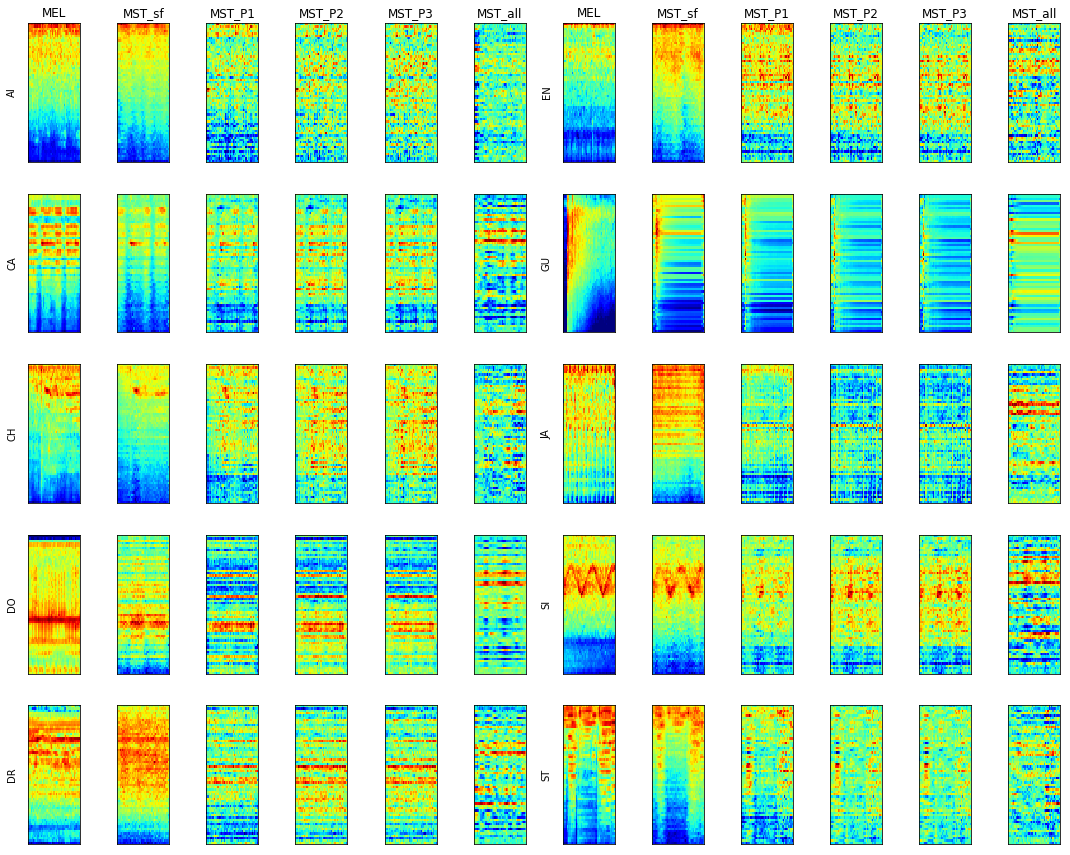

horizontal direction: time, vertical direction: frequency


In [7]:
fig, axes = plt.subplots(5,12) 
fig.tight_layout()  
mpl.rcParams['figure.figsize'] = [15,12]
audioclass = ['AI', 'CA', 'CH', 'DO', 'DR', 'EN', 'GU', 'JA', 'SI', 'ST']
print("horizontal direction: time, vertical direction: frequency")
for i in range(2):
    for j in range(5):
        ax_idx = i*6 + j*12
        class_idx = i*5 + j
  
        # Plot MEL-spectrogram
        ax = axes.flatten()[ax_idx]
        axes_work(ax)
        ax.set_ylabel(audioclass[class_idx])
        if((class_idx == 0) | (class_idx == 5)):
            ax.set_title('MEL');
        to_plot = all_spcgm[class_idx,:,:]
        img = ax.imshow(to_plot, interpolation='nearest', cmap='jet', extent = [0, 1, 0, 1])
        ax.set_aspect('auto')
        
        # Plot MST_sf
        ax = axes.flatten()[ax_idx +1]
        axes_work(ax)
        if((class_idx == 0) | (class_idx == 5)):
            ax.set_title('MST_sf');
        to_plot = np.reshape(MST_act[0][class_idx,:,:],[60,41])
        img = ax.imshow(to_plot, interpolation='nearest', cmap='jet', extent = [0, 1, 0, 1])
        ax.set_aspect('auto')
        
        # Plot MST_P1
        ax = axes.flatten()[ax_idx +2]
        axes_work(ax)
        if((class_idx == 0) | (class_idx == 5)):
            ax.set_title('MST_P1');
        to_plot = np.reshape(MST_act[1][class_idx,:,:],[60,41])
        img = ax.imshow(to_plot, interpolation='nearest', cmap='jet', extent = [0, 1, 0, 1])
        ax.set_aspect('auto')
        
        # Plot MST_P2
        ax = axes.flatten()[ax_idx +3]
        axes_work(ax)
        if((class_idx == 0) | (class_idx == 5)):
            ax.set_title('MST_P2');
        to_plot = np.reshape(MST_act[2][class_idx,:,:],[60,41])
        img = ax.imshow(to_plot, interpolation='nearest', cmap='jet', extent = [0, 1, 0, 1])
        ax.set_aspect('auto')
        
        # Plot MST_P3
        ax = axes.flatten()[ax_idx +4]
        axes_work(ax)
        if((class_idx == 0) | (class_idx == 5)):
            ax.set_title('MST_P3');
        to_plot = np.reshape(MST_act[3][class_idx,:,:],[60,41])
        img = ax.imshow(to_plot, interpolation='nearest', cmap='jet', extent = [0, 1, 0, 1])
        ax.set_aspect('auto')
        
        # Plot MST_all
        ax = axes.flatten()[ax_idx +5]
        axes_work(ax)
        if((class_idx == 0) | (class_idx == 5)):
            ax.set_title('MST_all');
        to_plot = np.reshape(MST_act[4][class_idx,:,:],[60,41])
        img = ax.imshow(to_plot, interpolation='nearest', cmap='jet', extent = [0, 1, 0, 1])
        ax.set_aspect('auto')    
plt.show()
print("horizontal direction: time, vertical direction: frequency")

The interested reader can now look at our [GitHub repository](https://github.com/pr3d1c70r/DybLSPB), in particular at the file DF_And_Pic.py. This is the file that produced most of the pretrained weights we used in this demo. Note, however, that the code won't run on your computer, since we would have to give you some big .mat files that contain our dataset.

You can also look at the repository of [the original work by Piczak himself](https://github.com/karoldvl/paper-2015-esc-convnet). There you can see the data preprocessing for example, from which we took a few lines.

**Thanks for reading!**